In [1]:
import lasagne
from lasagne.layers import *
import pydotplus as pydot
from IPython.display import Image

Original graph plotting code taken from here: https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/visualize.py

The code has been modified to support 'clusters' (which we'll do shortly), and also some minor aesthetic changes to the graph which I hope I can move out into another class/method in the future.

In [2]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

In [3]:
def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """
    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    #print dir(pydot_graph)
    pydot_nodes = {}
    pydot_edges = []
    pydot_clusters = {}
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        key = repr(layer)
        label = layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\n{0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, 
            label=label, 
            shape='hexagon', 
            fontname='Helvetica',
            fontcolor="#111111",
            fontsize=10,
            fillcolor=color, 
            style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])
            
        if hasattr(layer, 'cluster'):
            if layer.cluster not in pydot_clusters:
                pydot_clusters[layer.cluster] = pydot.Cluster(layer.cluster, label=layer.cluster)
            pydot_clusters[layer.cluster].add_node( pydot_nodes[key] )

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        edg = pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]])
        edg.set_style('dashed')
        pydot_graph.add_edge(edg)
        
    for cluster in pydot_clusters.values():
        pydot_graph.add_subgraph(cluster)
        
    return pydot_graph

----

In [13]:
def simple_net():
    l_in = InputLayer((None,1,28,28))
    # this conv block comprises a cluster called
    # 'conv_block1'
    l_conv = Conv2DLayer(l_in, num_filters=1, filter_size=3)
    l_conv.cluster = "conv_block1"
    l_conv2 = Conv2DLayer(l_conv, num_filters=1, filter_size=3)
    l_conv2.cluster = "conv_block1"
    # this conv block comprises a cluster called
    # 'conv_block2
    l_conv_a = Conv2DLayer(l_in, num_filters=1, filter_size=3)
    l_conv_a.cluster = "conv_block2"
    l_conv2_a = Conv2DLayer(l_conv_a, num_filters=1, filter_size=3)
    l_conv2_a.cluster = "conv_block2"
    #--
    l_concat = ConcatLayer([l_conv2, l_conv2_a])
    l_dense = DenseLayer(l_concat, num_units=1)
    return l_dense

In [14]:
for layer in get_all_layers(simple_net()):
    print layer

In [15]:
make_pydot_graph(get_all_layers(simple_net()), output_shape=True, verbose=False).write_png("test.png")

True

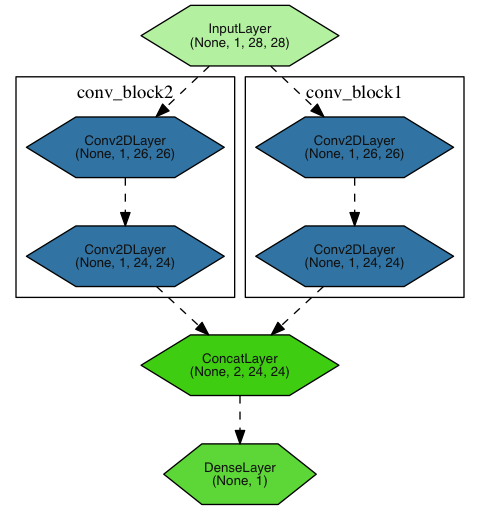

In [16]:
Image("./test.png")